In [61]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

pio.templates.default = "plotly_white"

In [62]:
import sys
sys.path.append('../../../')

from src.transformer_utils  import encode_labels

## 1. Chargement du jeu de donnnées

In [63]:
df = pd.read_csv('../../../data/outputs/05_merged_data.csv')

In [64]:
print(df.shape)
df.head()

(26080, 24)


,resultId,raceId,driverId,constructorId,grid,race_rank,points,laps,milliseconds,fastestLap,...,round,circuitId,circuit_name,constructor_name,country,constructor_is_active,nationality,driver_is_active,full_name,season_age
0,1,18,1,1,1,1,10.0,58,5690616,39,...,1,1,Australian Grand Prix,McLaren,British,1,British,1,Lewis Hamilton,23
1,2,18,2,2,5,2,8.0,58,5696094,41,...,1,1,Australian Grand Prix,BMW Sauber,German,0,German,0,Nick Heidfeld,31
2,3,18,3,3,7,3,6.0,58,5698779,41,...,1,1,Australian Grand Prix,Williams,British,1,German,0,Nico Rosberg,23
3,4,18,4,4,11,4,5.0,58,5707797,58,...,1,1,Australian Grand Prix,Renault,French,0,Spanish,1,Fernando Alonso,27
4,5,18,5,1,3,5,4.0,58,5708630,43,...,1,1,Australian Grand Prix,McLaren,British,1,Finnish,0,Heikki Kovalainen,27


## 2. Séparation des Caractéristiques et de la variable cible

In [65]:
cols = df.select_dtypes(np.object_).columns
features_df = df.drop(cols, axis=1)
features_df.drop('race_rank', axis=1, inplace=True)
target_df = pd.Categorical(df['race_rank'])

In [66]:
features_df.head()

,resultId,raceId,driverId,constructorId,grid,points,laps,milliseconds,fastestLap,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,constructor_is_active,driver_is_active,season_age
0,1,18,1,1,1,10.0,58,5690616,39,87452,218.300,1,2008,1,1,1,1,23
1,2,18,2,2,5,8.0,58,5696094,41,87739,217.586,1,2008,1,1,0,0,31
2,3,18,3,3,7,6.0,58,5698779,41,88090,216.719,1,2008,1,1,1,0,23
3,4,18,4,4,11,5.0,58,5707797,58,88603,215.464,1,2008,1,1,0,1,27
4,5,18,5,1,3,4.0,58,5708630,43,87418,218.385,1,2008,1,1,1,0,27


In [67]:
target_df

[1, 2, 3, 4, 5, ..., 16, 17, 18, 19, 20]
Length: 26080
Categories (39, int64): [1, 2, 3, 4, ..., 36, 37, 38, 39]

In [68]:
# Séparation de notre jeu de données, 30% de test et 70% d'entrainement
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.25, random_state=42)

## 3. Décomposition ACP

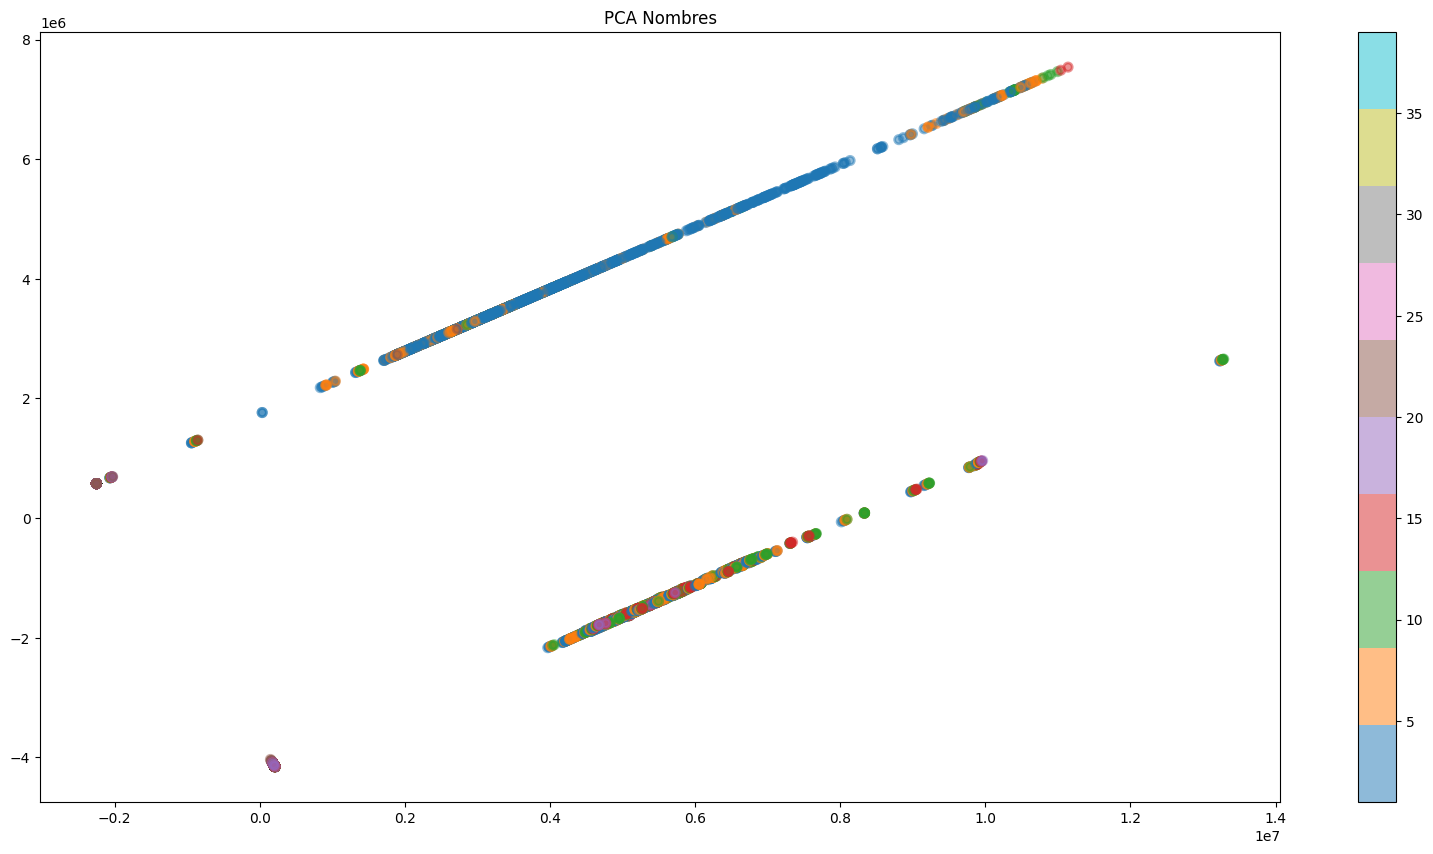

In [69]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(features_df)

plt.figure(1, figsize=(20, 10))
plt.scatter(
    x_pca[:, 0], x_pca[:, 1], c=target_df, alpha=0.5, lw=2, cmap="tab10"
)

plt.title("PCA Nombres")
plt.colorbar()

## 4. UMAP
### 4.1. Clusterisation

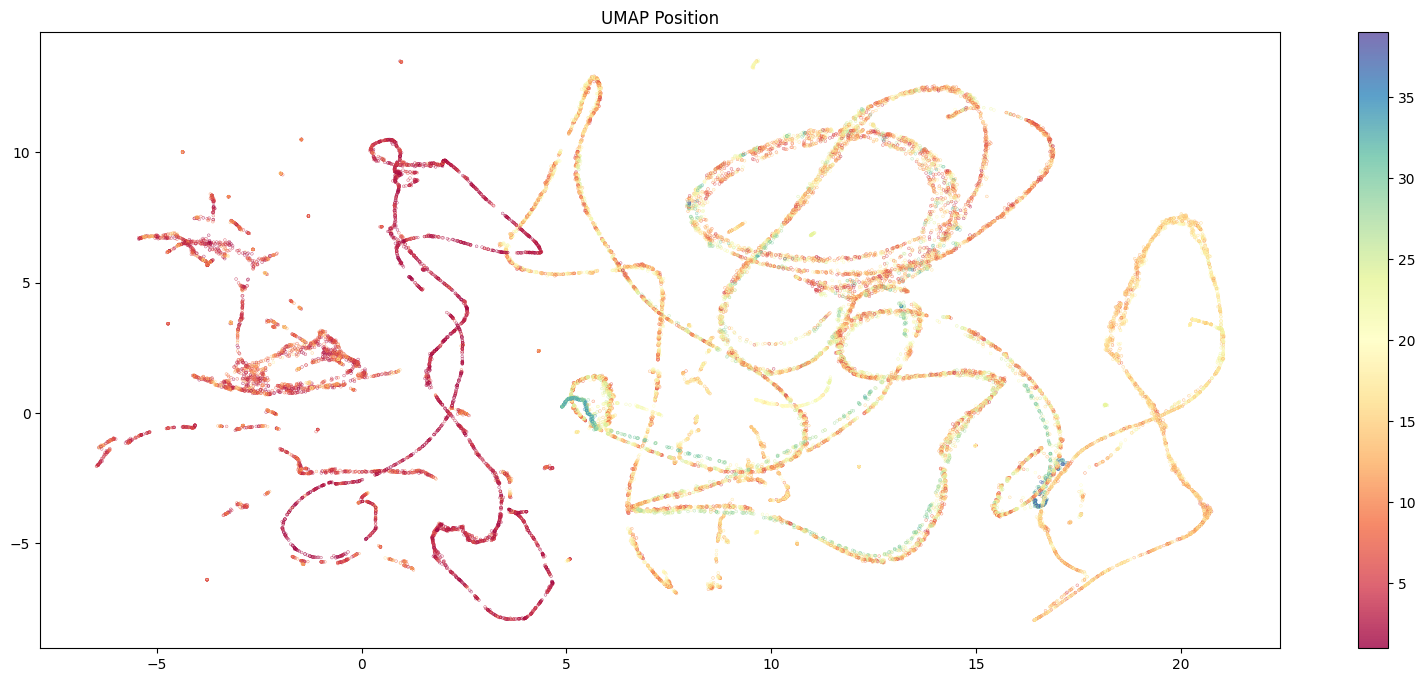

In [71]:
reducer = UMAP(n_components=3, min_dist=0.3, metric='correlation', n_jobs=-1, verbose=False, n_neighbors=50)
embedding = reducer.fit_transform(features_df)

plt.figure(1, figsize=(20, 8))
plt.scatter(
    embedding[:, 0], embedding[:, 1], s=0.1, c=target_df, alpha=0.8, lw=2, cmap="Spectral"
)

plt.title("UMAP Position")
plt.colorbar()

### 4.2. Calcul du score

In [70]:
def umap_dim_score():
    my_umap = UMAP(n_components=3, min_dist=0.3, metric='correlation', n_jobs=-1, verbose=False, n_neighbors=50)
    x_train_low = my_umap.fit_transform(X_train)
    x_test_low = my_umap.transform(X_test)
    kmeans = KMeans(n_clusters=25, random_state=0, n_init="auto").fit(x_train_low)
    y_pred = pd.Categorical(kmeans.predict(x_test_low))
    return f1_score(y_test, y_pred, average='macro')

score_high_dim = [umap_dim_score() for _ in range(10)]
print(f"Moyenne du score : {np.mean(score_high_dim):.4f}")
print(f"Ecart-type du score : {np.std(score_high_dim):.4f}")

Moyenne du score : 0.0234
Ecart-type du score : 0.0030
